### 2016 - 2020 Presidential Election Comparison

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [2]:
# Helpful constants

# Party colors
COLOR_DEM_BLUE = "#0055A4"
COLOR_REP_RED = "#E9141D"

# Cutoff for considering a county "big"
COUNTY_CARE_COUNT = 100000

# According to https://ballotpedia.org/Presidential_battleground_states,_2020
# These states were deemed to be competitive in the 2020 election:
BATTLEGROUND_STATES = ["arizona", "florida", "georgia", "iowa", "michigan",
                       "minnesota", "nevada", "new hampshire", "north carolina", 
                       "ohio", "pennsylvania", "texas", "wisconsin"]

# These states went to Trump in 2016, and Biden in 2020:
FLIPPED_STATES = ["pennsylvania", "wisconsin", "michigan", "georgia", "arizona"]

In [3]:
# This is just a function I like using to get an overview of a large data frame:
def print_df_overview(df, title):        
    print(f"{title} DF Head:")
    print(df.head())
    print("----------------------------------")
    print(f"{title} DF dtypes:")
    print(df.dtypes)
    
    for col in df.columns:
        print("----------------------------------")
        print(f"{title} DF column value counts:")

        ABRIDGED_ROWS = 16
        counts = df[col].value_counts()
        if counts.size < 2*ABRIDGED_ROWS:
            # Print the counts all together
            print(col, "counts:")    
            print(counts)
        else:
            # Print top and bottom counts
            print(col, "top counts:")
            print(counts[0:ABRIDGED_ROWS])
            print(col, "bottom counts:")
            print(counts[-ABRIDGED_ROWS:])

In [4]:
# The data files are too big to naively manage in git, so they are stored as zip files.

# Unzip a file to a specified location:
def unzip(zip, where):
    with ZipFile(zip, 'r') as zObject:   
        print(f"Unzipping {zip} to {where}")
        zObject.extractall(path=where) 

# Paths for data files, before and after unzipping
path_2016 = os.path.join('.', 'resources', '2016')
path_2016_csv = os.path.join('.', 'resources', '2016', '2016-precinct-president.csv')
path_2016_zip = os.path.join('.', 'resources', '2016', '2016-precinct-president.csv.zip')
path_2020 = os.path.join('.', 'resources', '2020')
path_2020_csv = os.path.join('.', 'resources', '2020', 'PRESIDENT_precinct_general.csv')
path_2020_zip = os.path.join('.', 'resources', '2020', 'PRESIDENT_precinct_general.csv.zip')

# Unzip the data files
unzip(path_2016_zip, path_2016)
unzip(path_2020_zip, path_2020)

Unzipping .\resources\2016\2016-precinct-president.csv.zip to .\resources\2016
Unzipping .\resources\2020\PRESIDENT_precinct_general.csv.zip to .\resources\2020


In [5]:
# Read raw data -- takes several seconds

# Encoding wasn't documented for 2016 but ISO-8859-1 seems to work fine. 
# Some data types are specified here to suppress warnings
raw_2016_df = pd.read_csv(path_2016_csv, encoding="ISO-8859-1", 
                          dtype={"precinct":str, "district":str, "party":str, "candidate_fec":str, "candidate_fec_name":str, "votes":int} )

# The 2020 data actually includes the encoding and column data types (thanks!):
official_2020_dtypes = {'precinct':str,'office':str, 'party_detailed':str, 
		'party_simplified':str,'mode':str,'votes':int, 'county_name':str,
		'county_fips':str, 'jurisdiction_name':str,'jurisdiction_fips':str,
		'candidate':str, 'district':str, 'dataverse':str,'year':int,
		'stage':str, 'state':str, 'special':str, 'writein':str, 'state_po':str,
		'state_fips':str, 'state_cen':str, 'state_ic':str, 'date':str, 
		'readme_check':str,'magnitude':int}
raw_2020_df = pd.read_csv(path_2020_csv, encoding="ISO-8859-1", dtype=official_2020_dtypes )

raw_2016_df.shape, raw_2020_df.shape

((1989234, 37), (1982581, 25))

In [6]:
# Clean up the two data sets

# Get ready to clean up
c_2016_df = raw_2016_df.copy()
c_2020_df = raw_2020_df.copy()
print("Initial:                 ", c_2016_df.shape, c_2020_df.shape)

# Results include "statistial adjustments" which I'm ignoring for the moment
c_2016_df = c_2016_df.drop(c_2016_df[c_2016_df.precinct == "Statistical Adjustments"].index)
c_2020_df = c_2020_df.drop(c_2020_df[c_2020_df.jurisdiction_name == "{STATISTICAL ADJUSTMENTS}"].index)
print("Drop adjustments:        ", c_2016_df.shape, c_2020_df.shape)

# Also remove any negative votes -- I don't know what they mean
c_2016_df = c_2016_df.drop(c_2016_df[c_2016_df.votes < 0].index)
c_2020_df = c_2020_df.drop(c_2020_df[c_2020_df.votes < 0].index)
print("Drop negative votes:     ", c_2016_df.shape, c_2020_df.shape)

# Narrow down to the interesting columns.
c_2016_df = c_2016_df.loc[:, ["state", "county_name", "candidate", "votes"] ]
c_2020_df = c_2020_df.loc[:, ["state", "county_name", "candidate", "votes"] ]
print("Drop extraneous columns: ", c_2016_df.shape, c_2020_df.shape)

# Change a couple column names for consistency and conciseness
c_2016_df.rename(columns={"county_name": "county"}, inplace=True)
c_2020_df.rename(columns={"county_name": "county"}, inplace=True)

# 2016 uses normal capitalization while 2020 uses all caps
# So, California vs CALIFORNIA, and District of Columbia vs DISTRICT OF COLUMBIA
# To reconcile them, force everything to lowercase.
c_2016_df["state"] = c_2016_df["state"].str.lower()
c_2016_df["county"] = c_2016_df["county"].str.lower()
c_2016_df["candidate"] = c_2016_df["candidate"].str.lower()
c_2020_df["state"] = c_2020_df["state"].str.lower()
c_2020_df["county"] = c_2020_df["county"].str.lower()
c_2020_df["candidate"] = c_2020_df["candidate"].str.lower()

# County names actually say "county" in the 2016 data, so remove that
c_2016_df["county"] = c_2016_df["county"].str.replace(" county", "")

# Reconcile candidate names. Clinton and Biden are equivalent for our purposes, 
# and Biden and Trump both appear in multiple forms in the datasets.
# Any other candidate is just "other".
dem_names = ["hillary clinton", "biden, joe", "joseph biden", "joseph r biden"]
rep_names = ["donald trump", "donald j trump"]
combo = dem_names + rep_names
c_2016_df.loc[~c_2016_df["candidate"].isin(combo), "candidate"] = "other"
c_2020_df.loc[~c_2020_df["candidate"].isin(combo), "candidate"] = "other"
c_2016_df.loc[c_2016_df["candidate"].isin(dem_names), "candidate"] = "the dem"
c_2016_df.loc[c_2016_df["candidate"].isin(rep_names), "candidate"] = "trump"
c_2020_df.loc[c_2020_df["candidate"].isin(dem_names), "candidate"] = "the dem"
c_2020_df.loc[c_2020_df["candidate"].isin(rep_names), "candidate"] = "trump"

# Display some info before and after cleaning, to get a sense of how much was dropped:
print("2016:")
raw_rows = raw_2016_df.shape[0]
raw_votes = raw_2016_df['votes'].sum()
clean_rows = c_2016_df.shape[0]
clean_votes = c_2016_df['votes'].sum()
print(f"Original: {raw_rows:7} rows, {raw_votes:10} votes")
print(f"Cleaned:  {clean_rows:7} rows, {clean_votes:10} votes -- {clean_rows / raw_rows:.3%} and {clean_votes / raw_votes:.3%}")

print("2020:")
raw_rows = raw_2020_df.shape[0]
raw_votes = raw_2020_df['votes'].sum()
clean_rows = c_2020_df.shape[0]
clean_votes = c_2020_df['votes'].sum()
print(f"Original: {raw_rows:7} rows, {raw_votes:10} votes")
print(f"Cleaned:  {clean_rows:7} rows, {clean_votes:10} votes -- {clean_rows / raw_rows:.3%} and {clean_votes / raw_votes:.3%}")

Initial:                  (1989234, 37) (1982581, 25)
Drop adjustments:         (1988506, 37) (1982207, 25)
Drop negative votes:      (1988502, 37) (1974972, 25)
Drop extraneous columns:  (1988502, 4) (1974972, 4)
2016:
Original: 1989234 rows,  140070880 votes
Cleaned:  1988502 rows,  140064901 votes -- 99.963% and 99.996%
2020:
Original: 1982581 rows,  157743486 votes
Cleaned:  1974972 rows,  157753369 votes -- 99.616% and 100.006%


In [7]:
# Just some debug output for during development
#print_df_overview(c_2016_df, "2016 Cleaned")
#print_df_overview(c_2020_df, "2020 Cleaned")

In [8]:
# The two dataframes are so large at this point that merging or joining them is problematic.
# I kept running out of memory. So we squash them down a lot first, summing up the votes for
# each candidate in each county. Combining all the "other" rows reduces dataframe size
# tremendously, making them much easier to deal with:
grouped_2016 = pd.DataFrame(c_2016_df.groupby(["state", "county", "candidate"])["votes"].sum())
grouped_2020 = pd.DataFrame(c_2020_df.groupby(["state", "county", "candidate"])["votes"].sum())
combo_df = pd.merge(grouped_2016, grouped_2020, on=["state", "county", "candidate"], suffixes=["_2016", "_2020"])

# The actions above result in a "multi index" dataframe, which I don't really want.
# So do regular old simple indexing:
combo_df.reset_index(inplace=True)

print_df_overview(combo_df, "Combo DF")

Combo DF DF Head:
     state   county candidate  votes_2016  votes_2020
0  alabama  autauga     other       12892         516
1  alabama  autauga   the dem        5936        7503
2  alabama  autauga     trump       18172       19838
3  alabama  baldwin     other       55584        1890
4  alabama  baldwin   the dem       18458       24578
----------------------------------
Combo DF DF dtypes:
state         object
county        object
candidate     object
votes_2016     int64
votes_2020     int64
dtype: object
----------------------------------
Combo DF DF column value counts:
state top counts:
state
texas             762
georgia           477
virginia          399
kentucky          360
missouri          324
kansas            315
illinois          303
north carolina    300
iowa              297
tennessee         285
nebraska          279
ohio              264
minnesota         258
mississippi       246
michigan          243
oklahoma          231
Name: count, dtype: int64
state bottom c

In [9]:
# Add vote totals columns
combo_df["total_2016"] = ""
combo_df["total_2020"] = ""

for state in combo_df["state"].unique():
    state_slice = combo_df.loc[combo_df["state"] == state]
    counties = state_slice["county"].unique()
    for county in counties:
        county_slice = state_slice.loc[combo_df["county"] == county]        
        total_2016 = county_slice["votes_2016"].sum()
        total_2020 = county_slice["votes_2020"].sum()

        combo_df.loc[county_slice.index, "total_2016"] = total_2016
        combo_df.loc[county_slice.index, "total_2020"] = total_2020

combo_df

,state,county,candidate,votes_2016,votes_2020,total_2016,total_2020
0,alabama,autauga,other,12892,516,37000,27857
1,alabama,autauga,the dem,5936,7503,37000,27857
2,alabama,autauga,trump,18172,19838,37000,27857
3,alabama,baldwin,other,55584,1890,146925,110012
4,alabama,baldwin,the dem,18458,24578,146925,110012
...,...,...,...,...,...,...,...
8954,wyoming,washakie,the dem,532,651,3814,4032
8955,wyoming,washakie,trump,2911,3245,3814,4032
8956,wyoming,weston,other,194,93,3526,3560
8957,wyoming,weston,the dem,299,360,3526,3560


In [10]:
# Add the columns showing percentages and changes from 2016-2020
combo_df["pct_2016"] = combo_df["votes_2016"] / combo_df["total_2016"]
combo_df["pct_2020"] = combo_df["votes_2020"] / combo_df["total_2020"]
combo_df["votes_change"] = combo_df["votes_2020"] - combo_df["votes_2016"]
combo_df["pct_change"] = combo_df["pct_2020"] - combo_df["pct_2016"]

# Save to CSV to enable some manual sanity checks
combo_df.to_csv("combined.csv")

# Make the DF for the biggest counties
big_counties_df = combo_df.loc[combo_df["total_2016"] >= COUNTY_CARE_COUNT].loc[combo_df["total_2020"] >= COUNTY_CARE_COUNT]

# Note many counties we have data for. This doesn't impact any calculation directly, but is nice to know:
county_count = len(combo_df["county"].unique())
big_county_count = len(big_counties_df["county"].unique())
county_count, big_county_count

(1755, 243)

In [16]:
# I have a lot of boxplots, and this little function is for adding median values as text
# just above the median line in the box:
def add_percent_above_value(subplot, x, ylim, value, digits=0, color="black"):
    range = ylim[1] - ylim[0]
    voffset = range * 0.015
    subplot.text(x, value + voffset, f"{value:.{digits}%}", va='center', ha='center', color=color, weight='bold')  

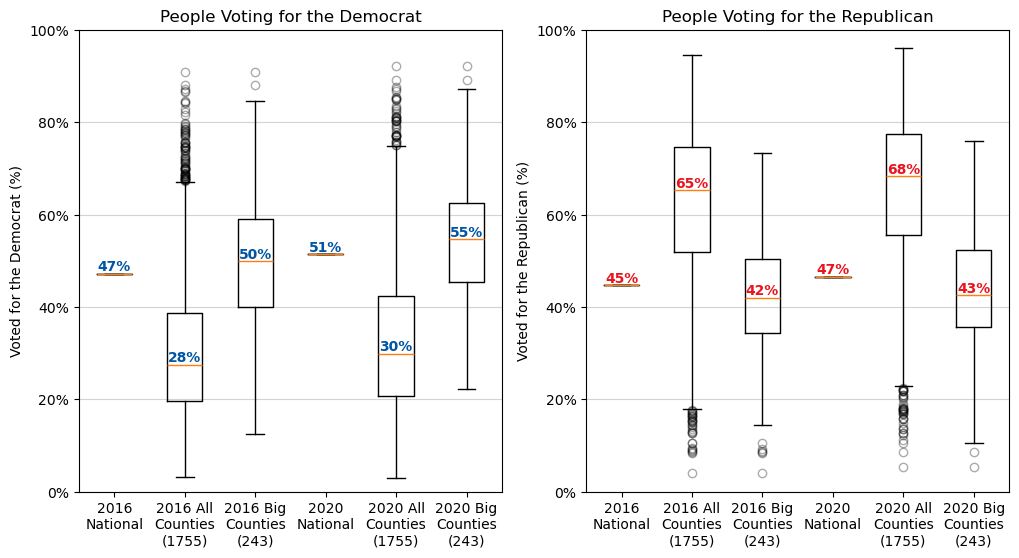

In [17]:
# This function makes a boxplot showing national, all county, and big county percentages
# for both election years:
def plot_result_comparisons(subplot, candidate_str, title, color):
    national_gb = combo_df.groupby("candidate").sum()
    candidate = candidate_str

    national_pct_2016 = national_gb["votes_2016"][candidate_str] / national_gb["votes_2016"].sum()
    national_pct_2020 = national_gb["votes_2020"][candidate_str] / national_gb["votes_2020"].sum()

    combo_slice = combo_df.loc[combo_df["candidate"] == candidate_str]
    big_slice = big_counties_df.loc[big_counties_df["candidate"] == candidate_str]

    # Thanks to: https://stackoverflow.com/questions/25973581/how-to-format-axis-number-format-to-thousands-with-a-comma
    subplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))

    subplot.boxplot(
            [national_pct_2016, combo_slice["pct_2016"], big_slice["pct_2016"],
             national_pct_2020, combo_slice["pct_2020"], big_slice["pct_2020"]],
            tick_labels = ["2016\nNational", f"2016 All\nCounties\n({county_count})", f"2016 Big\nCounties\n({big_county_count})", 
                           "2020\nNational", f"2020 All\nCounties\n({county_count})", f"2020 Big\nCounties\n({big_county_count})"],
            flierprops= {"alpha": 0.33} )
    subplot.set_title(f"People Voting for {title}")
    subplot.set_ylabel(f"Voted for {title} (%)")
    subplot.set_ylim((0,1))
    subplot.grid(axis="y", which="major", color="lightgrey")

    add_percent_above_value(subplot, 1, subplot.get_ylim(), national_pct_2016, color=color)
    add_percent_above_value(subplot, 2, subplot.get_ylim(), combo_slice["pct_2016"].median(), color=color)
    add_percent_above_value(subplot, 3, subplot.get_ylim(), big_slice["pct_2016"].median(), color=color)
    add_percent_above_value(subplot, 4, subplot.get_ylim(), national_pct_2020, color=color)
    add_percent_above_value(subplot, 5, subplot.get_ylim(), combo_slice["pct_2020"].median(), color=color)
    add_percent_above_value(subplot, 6, subplot.get_ylim(), big_slice["pct_2020"].median(), color=color)

# Side-by-size boxplots for results for both major candidates:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
plot_result_comparisons(ax1, "the dem", "the Democrat", COLOR_DEM_BLUE)
plot_result_comparisons(ax2, "trump", "the Republican", COLOR_REP_RED)
plt.show()

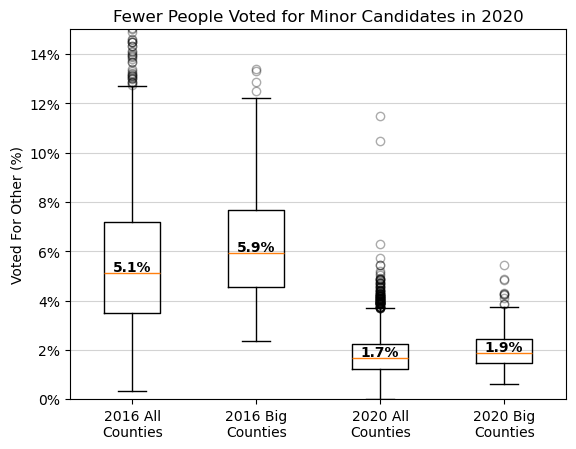

In [20]:
# Show a boxplot for people voting for "other" candidates, meaning anyone but the two
# main party nominees, in 2016 and 2020.
combo_slice = combo_df.loc[combo_df["candidate"] == "other"]
big_slice = big_counties_df.loc[big_counties_df["candidate"] == "other"]

plt.axes().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
plt.boxplot(
        [combo_slice["pct_2016"], big_slice["pct_2016"],
         combo_slice["pct_2020"], big_slice["pct_2020"]],
        tick_labels = ["2016 All\nCounties", "2016 Big\nCounties", 
                       "2020 All\nCounties", "2020 Big\nCounties"],
        flierprops= {"alpha": 0.33} )
plt.title("Fewer People Voted for Minor Candidates in 2020")
plt.ylabel("Voted For Other (%)")
plt.ylim((0,0.15))
plt.grid(axis="y", which="major", color="lightgrey")

add_percent_above_value(plt, 1, plt.ylim(), combo_slice["pct_2016"].median(), digits=1)
add_percent_above_value(plt, 2, plt.ylim(), big_slice["pct_2016"].median(), digits=1)
add_percent_above_value(plt, 3, plt.ylim(), combo_slice["pct_2020"].median(), digits=1)
add_percent_above_value(plt, 4, plt.ylim(), big_slice["pct_2020"].median(), digits=1)

plt.show()

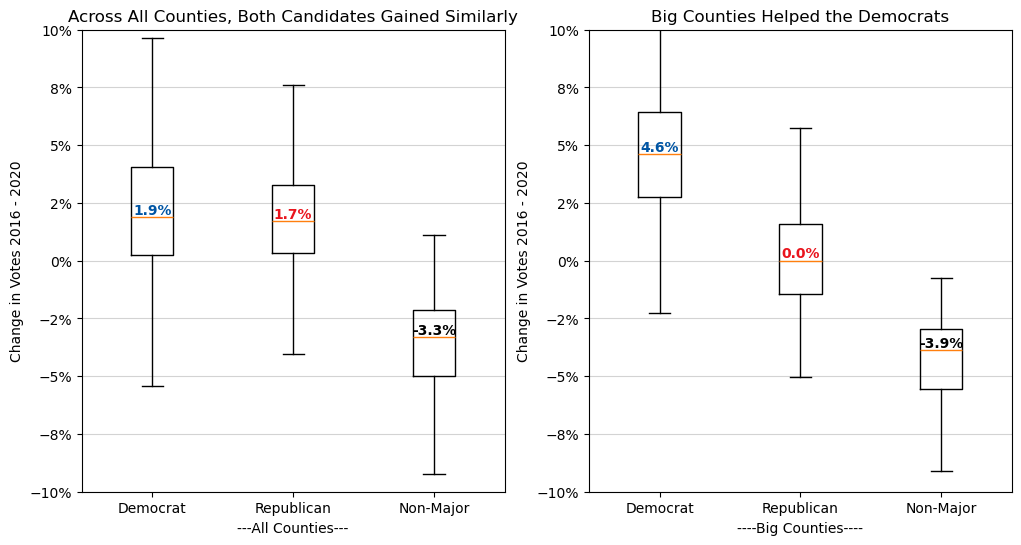

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
ax1.boxplot(
        [combo_df.loc[combo_df["candidate"] == "the dem"]["pct_change"], 
         combo_df.loc[combo_df["candidate"] == "trump"]["pct_change"],
         combo_df.loc[combo_df["candidate"] == "other"]["pct_change"]],
        tick_labels = ["Democrat", "Republican", "Non-Major"],
        showfliers=False )
ax1.set_title("Across All Counties, Both Candidates Gained Similarly")
ax1.set_ylabel("Change in Votes 2016 - 2020")
ax1.set_xlabel("---All Counties---")
ax1.set_ylim((-.1,.1))
ax1.grid(axis="y", which="major", color="lightgrey")


add_percent_above_value(ax1, 1, ax1.get_ylim(), combo_df.loc[combo_df["candidate"] == "the dem"]["pct_change"].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax1, 2, ax1.get_ylim(), combo_df.loc[combo_df["candidate"] == "trump"]["pct_change"].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax1, 3, ax1.get_ylim(), combo_df.loc[combo_df["candidate"] == "other"]["pct_change"].median(), digits=1)

# Thanks to: https://stackoverflow.com/questions/25973581/how-to-format-axis-number-format-to-thousands-with-a-comma
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
ax2.boxplot(
        [big_counties_df.loc[big_counties_df["candidate"] == "the dem"]["pct_change"], 
         big_counties_df.loc[big_counties_df["candidate"] == "trump"]["pct_change"],
         big_counties_df.loc[big_counties_df["candidate"] == "other"]["pct_change"]],
        tick_labels = ["Democrat", "Republican", "Non-Major"],
        showfliers=False )
ax2.set_title("Big Counties Helped the Democrats")
ax2.set_ylabel("Change in Votes 2016 - 2020")
ax2.set_xlabel("----Big Counties----")
ax2.set_ylim((-.1,.1))
ax2.grid(axis="y", which="major", color="lightgrey")

add_percent_above_value(ax2, 1, ax2.get_ylim(), big_counties_df.loc[big_counties_df["candidate"] == "the dem"]["pct_change"].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax2, 2, ax2.get_ylim(), big_counties_df.loc[big_counties_df["candidate"] == "trump"]["pct_change"].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax2, 3, ax2.get_ylim(), big_counties_df.loc[big_counties_df["candidate"] == "other"]["pct_change"].median(), digits=1)
plt.show()

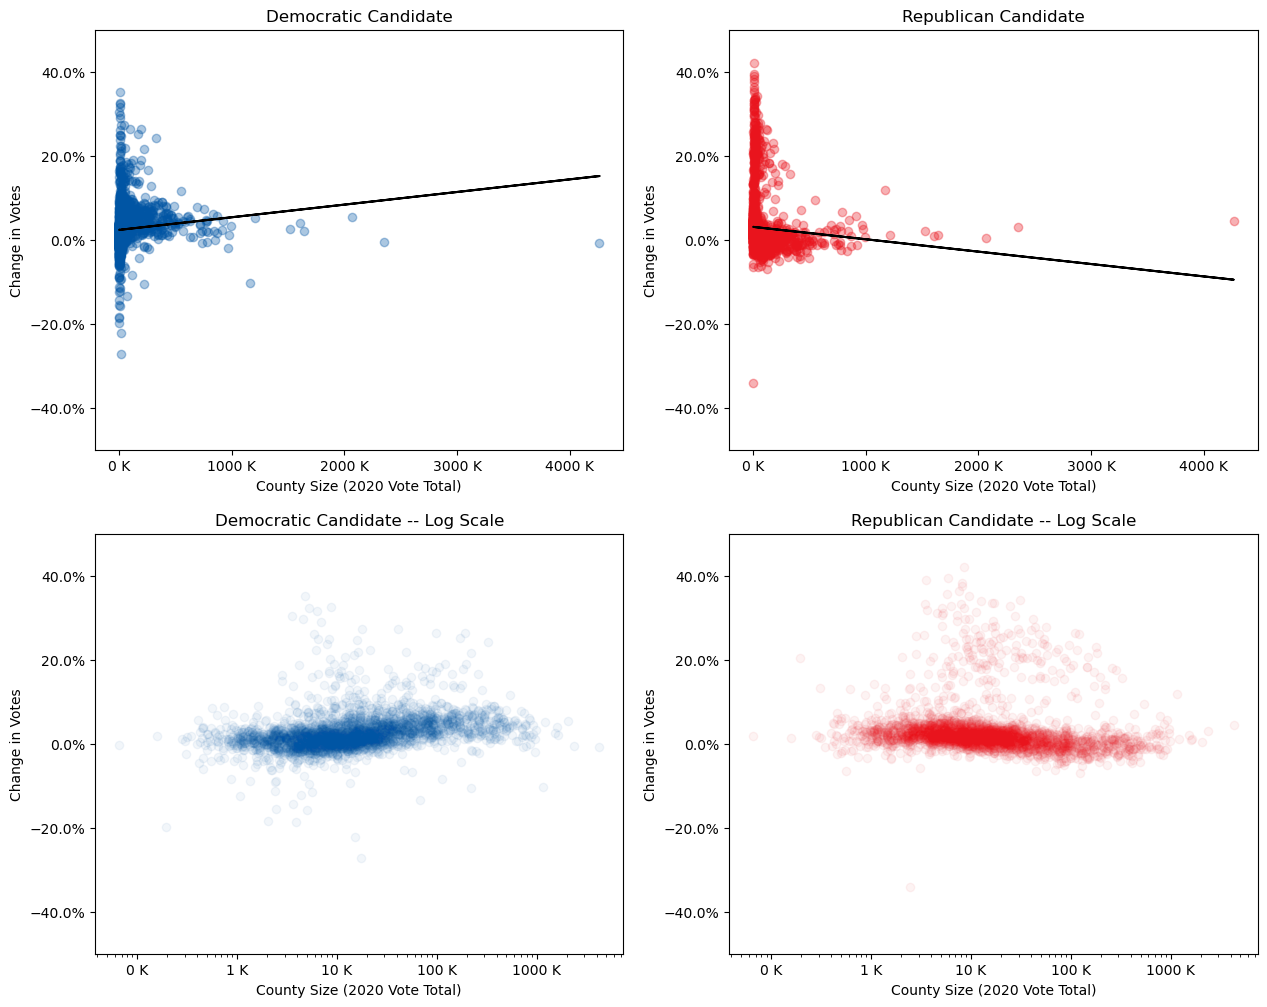

In [14]:
#Scatterplot showing relationship between county size and gain for party
def scatter_party(subplot, candidate_str, title, color, trendcolor, log):
    slice = combo_df.loc[combo_df["candidate"] == candidate_str]
    x = slice["total_2020"] / 1000
    y = slice["pct_change"]
    subplot.set_title(title)

    subplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.1%}"))    
    subplot.set_title(title)
    subplot.set_ylabel("Change in Votes")
    subplot.set_xlabel("County Size (2020 Vote Total)")
    subplot.set_ylim((-.5, 0.5))

    if log:
        subplot.scatter(x, y, color=color, alpha=0.05)
        subplot.set_xscale("log")
    else:
        subplot.scatter(x, y, color=color, alpha=0.33)
        subplot.set_xscale("linear") # AKA normal
    
        z = np.polyfit(list(x), list(y), 1)
        p = np.poly1d(z)
        subplot.plot(x,p(x),trendcolor)

    subplot.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0f} K"))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(15,12))
scatter_party(ax1, "the dem", "Democratic Candidate", COLOR_DEM_BLUE, "black", False)
scatter_party(ax2, "trump", "Republican Candidate", COLOR_REP_RED, "black", False)
scatter_party(ax3, "the dem", "Democratic Candidate -- Log Scale", COLOR_DEM_BLUE, "black", True)
scatter_party(ax4, "trump", "Republican Candidate -- Log Scale", COLOR_REP_RED, "black", True)
plt.show()

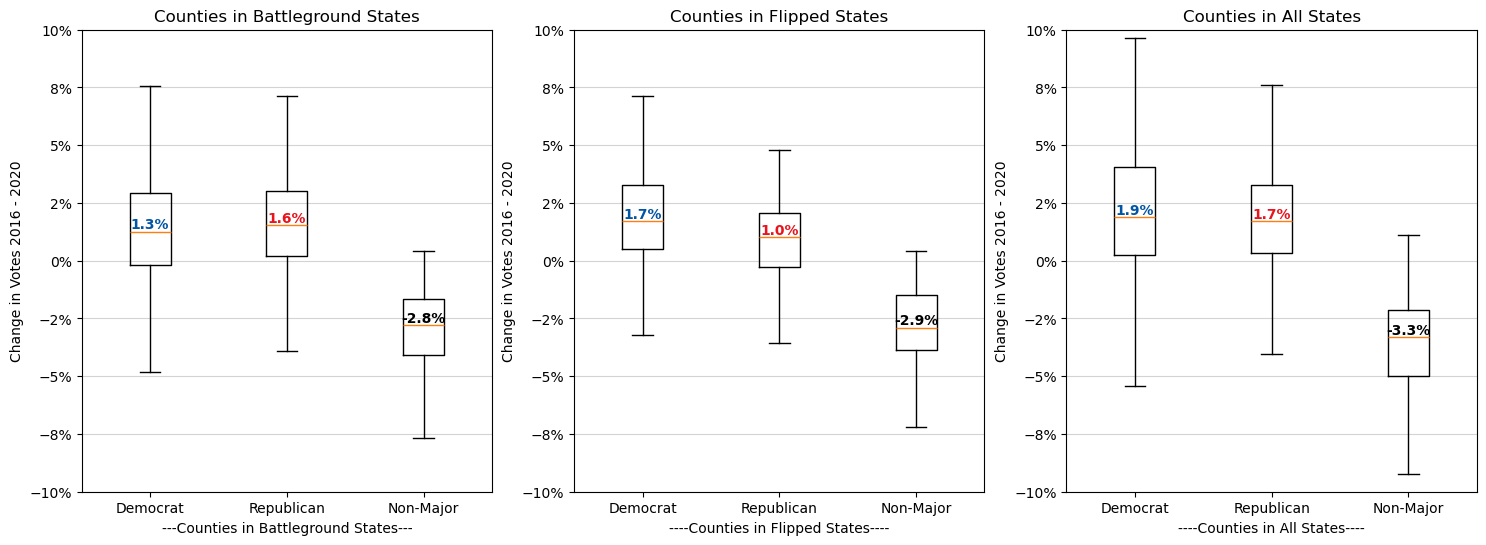

In [15]:
# Show shift betwen de
battleground_slice = combo_df.loc[combo_df["state"].isin(BATTLEGROUND_STATES)]
flipped_slice = combo_df.loc[combo_df["state"].isin(FLIPPED_STATES)]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,figsize=(18,6))

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
ax1.boxplot(
        [battleground_slice.loc[battleground_slice["candidate"] == "the dem"]["pct_change"], 
         battleground_slice.loc[battleground_slice["candidate"] == "trump"]["pct_change"],
         battleground_slice.loc[battleground_slice["candidate"] == "other"]["pct_change"]],
        tick_labels = ["Democrat", "Republican", "Non-Major"],
        showfliers=False )
ax1.set_title("Counties in Battleground States")
ax1.set_ylabel("Change in Votes 2016 - 2020")
ax1.set_xlabel("---Counties in Battleground States---")
ax1.set_ylim((-.1,.1))
ax1.grid(axis="y", which="major", color="lightgrey")


add_percent_above_value(ax1, 1, ax1.get_ylim(), battleground_slice.loc[battleground_slice["candidate"] == "the dem"]["pct_change"].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax1, 2, ax1.get_ylim(), battleground_slice.loc[battleground_slice["candidate"] == "trump"]["pct_change"].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax1, 3, ax1.get_ylim(), battleground_slice.loc[battleground_slice["candidate"] == "other"]["pct_change"].median(), digits=1)


ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
ax2.boxplot(
        [flipped_slice.loc[flipped_slice["candidate"] == "the dem"]["pct_change"], 
         flipped_slice.loc[flipped_slice["candidate"] == "trump"]["pct_change"],
         flipped_slice.loc[flipped_slice["candidate"] == "other"]["pct_change"]],
        tick_labels = ["Democrat", "Republican", "Non-Major"],
        showfliers=False )
ax2.set_title("Counties in Flipped States")
ax2.set_ylabel("Change in Votes 2016 - 2020")
ax2.set_xlabel("----Counties in Flipped States----")
ax2.set_ylim((-.1,.1))
ax2.grid(axis="y", which="major", color="lightgrey")

add_percent_above_value(ax2, 1, ax2.get_ylim(), flipped_slice.loc[flipped_slice["candidate"] == "the dem"]["pct_change"].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax2, 2, ax2.get_ylim(),  flipped_slice.loc[flipped_slice["candidate"] == "trump"]["pct_change"].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax2, 3, ax2.get_ylim(), flipped_slice.loc[flipped_slice["candidate"] == "other"]["pct_change"].median(), digits=1)


ax3.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
ax3.boxplot(
        [combo_df.loc[combo_df["candidate"] == "the dem"]["pct_change"], 
         combo_df.loc[combo_df["candidate"] == "trump"]["pct_change"],
         combo_df.loc[combo_df["candidate"] == "other"]["pct_change"]],
        tick_labels = ["Democrat", "Republican", "Non-Major"],
        showfliers=False )
ax3.set_title("Counties in All States")
ax3.set_ylabel("Change in Votes 2016 - 2020")
ax3.set_xlabel("----Counties in All States----")
ax3.set_ylim((-.1,.1))
ax3.grid(axis="y", which="major", color="lightgrey")

add_percent_above_value(ax3, 1, ax3.get_ylim(), combo_df.loc[combo_df["candidate"] == "the dem"]["pct_change"].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax3, 2, ax3.get_ylim(), combo_df.loc[combo_df["candidate"] == "trump"]["pct_change"].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax3, 3, ax3.get_ylim(), combo_df.loc[combo_df["candidate"] == "other"]["pct_change"].median(), digits=1)
plt.show()